In [1]:
from torch_geometric.datasets import ShapeNet
import os.path as osp
import torch
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
from utils.generate_graph import loss_vs_epoch
from torch_geometric.datasets import MNISTSuperpixels
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.utils import normalized_cut
from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x,
                                global_mean_pool)
from utils import pytorchtools
##utils
from utils.visualize_graph import visualize_MNISTSuperpixels
from torchsummary import summary
from utils.models import GCN1, GCN2


In [2]:
torch.cuda.set_device(1)
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
PATIENCE = 10

In [3]:

if not osp.exists('Mnist'):
    osp.makedirs('Mnist')

In [4]:
path = 'Mnist'
transform = T.Cartesian(cat=False)
train_dataset = MNISTSuperpixels(path, True, transform=transform)
test_dataset = MNISTSuperpixels(path, False, transform=transform)

train_ds  = torch.utils.data.Subset(train_dataset, range(0, 50000-1))
valid_ds = torch.utils.data.Subset(train_dataset, range(50000, 60000-1))


train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
valid_loader = DataLoader(valid_ds, batch_size=64)

d = train_dataset

## Visualize graph

Image Label: 0


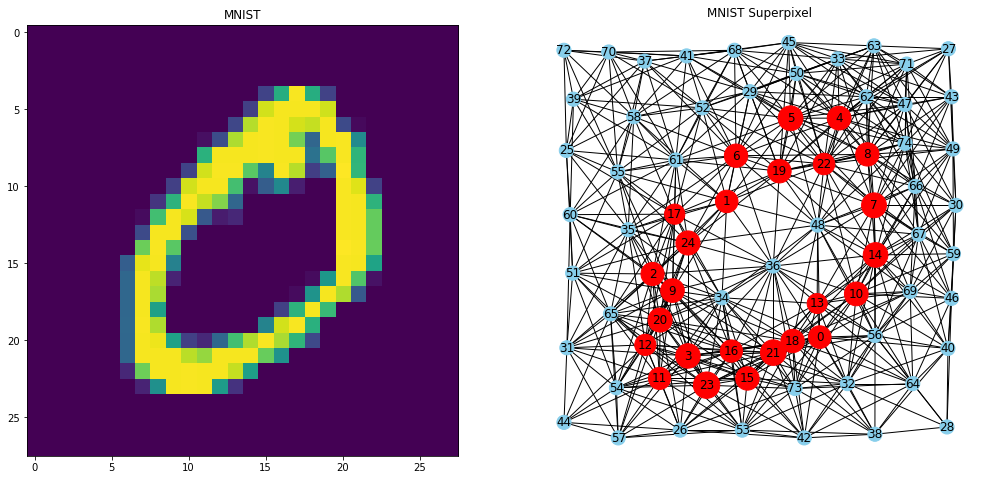

In [5]:
image_dataset = datasets.MNIST(root=path, download=True)
train_dataset = MNISTSuperpixels(root=path)
example = 1
image, label = image_dataset[example]
data = train_dataset[example]
print("Image Label:", label)
visualize_MNISTSuperpixels(image, data)

In [6]:
def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

## Network Architecture

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN1(d).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [8]:
model

GCN2(
  (conv1): SplineConv(1, 64, dim=2)
  (conv2): SplineConv(64, 128, dim=2)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [9]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

test_accuracies = []
valid_accuracies = []

In [10]:
def validate():
    model.eval()
    
    data_losses = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = criterion(model(data), data.y)
        loss.backward()
        optimizer.step()
        data_losses.append(loss.item())
        
    valid_loss = float(sum(data_losses) / len(data_losses))
    return valid_loss


In [11]:
def train(epoch):
    model.train()

    data_losses = []
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = criterion(model(data), data.y)
        loss.backward()
        optimizer.step()
        data_losses.append(loss.item())
        
    training_loss = float(sum(data_losses) / len(data_losses))
    return training_loss



In [12]:
def test():
    model.eval()
    correct_test = 0

    for data in test_loader:
        data = data.to(device)
        pred = model(data).max(1)[1]
        correct_test += pred.eq(data.y).sum().item()
    
    model.eval()
    
    correct_valid = 0
    for data in valid_loader:
        data = data.to(device)
        pred = model(data).max(1)[1]
        correct_valid += pred.eq(data.y).sum().item()
        

    
    return (correct_test/len(test_dataset)), (correct_valid / len(valid_ds))


Validation loss decreased (inf --> 0.646918).  Saving model ...
0
Validation loss decreased (0.646918 --> 0.493933).  Saving model ...
1
Validation loss decreased (0.493933 --> 0.431250).  Saving model ...
2
Validation loss decreased (0.431250 --> 0.395129).  Saving model ...
3
Validation loss decreased (0.395129 --> 0.370233).  Saving model ...
4
Validation loss decreased (0.370233 --> 0.343699).  Saving model ...
5
Validation loss decreased (0.343699 --> 0.329541).  Saving model ...
6
Validation loss decreased (0.329541 --> 0.315984).  Saving model ...
7
Validation loss decreased (0.315984 --> 0.305314).  Saving model ...
8
Validation loss decreased (0.305314 --> 0.292979).  Saving model ...
9
Validation loss decreased (0.292979 --> 0.290173).  Saving model ...
10
Validation loss decreased (0.290173 --> 0.279076).  Saving model ...
11
Validation loss decreased (0.279076 --> 0.274434).  Saving model ...
12
Validation loss decreased (0.274434 --> 0.264358).  Saving model ...
13
EarlySt

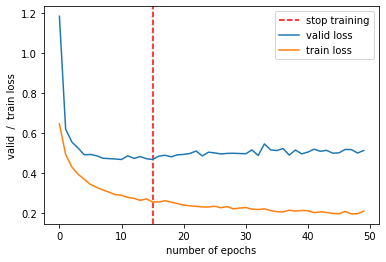

In [13]:
early_stopping = pytorchtools.EarlyStopping(patience=PATIENCE, verbose=True)

for epoch in range(NUM_EPOCHS):
    train_loss = train(epoch)
    valid_loss = validate()
    test_acc, valid_acc = test()

    
    test_accuracies.append(test_acc)
    valid_accuracies.append(valid_acc)
    
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    early_stopping(valid_loss, model)
    
    print(epoch)    
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
loss_vs_epoch(avg_train_losses, avg_valid_losses)

47


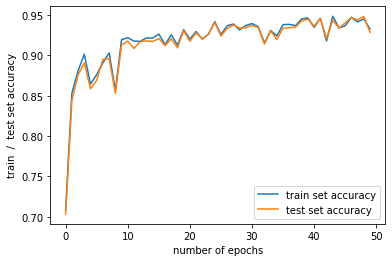

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('train  /  test set accuracy')
ax1.set_xlabel('number of epochs')
print(avg_valid_losses.index(min(avg_valid_losses)))
plt.plot(list(range(len(valid_accuracies))), valid_accuracies, label = "train set accuracy")
plt.plot(list(range(len(valid_accuracies))), test_accuracies, label="test set accuracy")
h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['train set accuracy','test set accuracy']
ax1.legend(labels=labels)
plt.show()